# Прогнозирование оттоĸа пользователей для фитнес-центров

## Описание проекта

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.

Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. Как понять, что клиент больше не с вами? Можно записать в отток тех, кто попросил закрыть договор или удалил аккаунт. Однако клиенты не всегда уходят демонстративно: чаще перестают пользоваться сервисом тихо.

Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал. Если клиент начал новую жизнь с понедельника, немного походил в спортзал, а потом пропал — скорее всего, он не вернётся.

Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество клиентских анкет. Ваша задача — провести анализ и подготовить план действий по удержанию клиентов.

Путь к файлу: /datasets/gym_churn.csv

### Описание данных
Данные клиента за предыдущий до проверки факта оттока месяц:
- `'gender'` — пол 0 женский, 1 мужской;

- `'Near_Location'` — проживание или работа в районе, где находится фитнес-центр;
- `'Partner'` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
- `'Promo_friends'` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- `'Phone'` — наличие контактного телефона;
- `'Age'` — возраст;
- `'Lifetime'` — время с момента первого обращения в фитнес-центр (в месяцах).

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
- `'Contract_period'` — длительность текущего действующего абонемента (месяц, 6 месяцев, год);

- `'Month_to_end_contract'` — срок до окончания текущего действующего абонемента (в месяцах);
- `'Group_visits'` — факт посещения групповых занятий;
- `'Avg_class_frequency_total'` — средняя частота посещений в неделю за все время с начала действия абонемента;
- `'Avg_class_frequency_current_month'` — средняя частота посещений в неделю за предыдущий месяц;
- `'Avg_additional_charges_total'` — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
- `'Churn'` — факт оттока в текущем месяце 0 остался, 1 ушел.

### Ход исследования

В процессе иследования мы:
- оценим исходные данные,
- проведем исследовательский анализ данных (EDA),
- построим модель прогнозирования оттока клиентов,
- сделаем кластеризацию клиентов,
- сформулируем выводы и дадим базовые рекомендации по работе с клиентами.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# стандартизация данных
from sklearn.preprocessing import StandardScaler

# разбивка на выборки
from sklearn.model_selection import train_test_split

# логистическая регрессия
from sklearn.linear_model import LogisticRegression

# cлучайный лес
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# метрики
from sklearn.metrics import accuracy_score, precision_score, recall_score

# кластеризация K-Means
from sklearn.cluster import KMeans

# дендограмма
from scipy.cluster.hierarchy import dendrogram, linkage

# создание собственных итераторов
import itertools

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Шаг 1. Загрузите данные

In [2]:
df = pd.read_csv('/datasets/gym_churn.csv')

In [3]:
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [4]:
# изменим порядок колонок
columns_order = (['gender','Near_Location','Partner','Promo_friends','Phone','Age','Lifetime',
                  'Contract_period','Month_to_end_contract','Group_visits','Avg_class_frequency_total',
                 'Avg_class_frequency_current_month','Avg_additional_charges_total','Churn'])
df = df[columns_order]

In [5]:
# приведем названия колонок к нижнему регистру
df.columns = df.columns.str.lower()

In [6]:
df.info()

print()
print(f'Колонок: {df.shape[1]}\nCтрок: {df.shape[0]}')
print('Количество пропусков:', df.isna().sum().sum())
print('Количество дубликатов:', df.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   age                                4000 non-null   int64  
 6   lifetime                           4000 non-null   int64  
 7   contract_period                    4000 non-null   int64  
 8   month_to_end_contract              4000 non-null   float64
 9   group_visits                       4000 non-null   int64  
 10  avg_class_frequency_total          4000 non-null   float64
 11  avg_class_frequency_current_month  4000 non-null   float

In [7]:
# приведем значения month_to_end_contract к целочисленному типу
df = df.astype({'month_to_end_contract':int})

##### Вывод

Загрузили данные, пропусков и дубликатов нет. Изменили порядок колонок. Значеня пола явно не определены, примем 0 - женский, 1 - мужской. Названия колонок привели к нижнему регистру. Количество месяцев привели к целому типу. Представленная информация позволит нам провести анализ и сделать выводы.

### Шаг 2. Проведите исследовательский анализ данных (EDA)

In [8]:
df.describe()

,gender,near_location,partner,promo_friends,phone,age,lifetime,contract_period,month_to_end_contract,group_visits,avg_class_frequency_total,avg_class_frequency_current_month,avg_additional_charges_total,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,29.184250,3.724750,4.681250,4.322750,0.412250,1.879020,1.767052,146.943728,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,3.258367,3.749267,4.549706,4.191297,0.492301,0.972245,1.052906,96.355602,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.148205,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,27.000000,1.000000,1.000000,1.000000,0.000000,1.180875,0.963003,68.868830,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,29.000000,3.000000,1.000000,1.000000,0.000000,1.832768,1.719574,136.220159,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,31.000000,5.000000,6.000000,6.000000,1.000000,2.536078,2.510336,210.949625,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,41.000000,31.000000,12.000000,12.000000,1.000000,6.023668,6.146783,552.590740,1.000000


Признаки: `gender`, `near_location`, `partner`, `promo_friends`, `phone`, `group_visits`, `churn` можно отнести к категриальным признакам со значениями 0 или 1. Остальные к числовым.

### Cредние значения признаков в двух группах — тех, кто ушел и тех, кто остался 

In [9]:
df.groupby('churn').mean().T

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
age,29.976523,26.989632
lifetime,4.711807,0.990575
contract_period,5.747193,1.728558
month_to_end_contract,5.283089,1.662582
group_visits,0.464103,0.268615


Клиенты в оттоке в среднем отличаются от оставшихся параметрами:
    - локация чуть дальше,
    - больше платят(меньше скидки),
    - чуть моложе,
    - меньше временные параметры пользования услугами,
    - меньше ходят на групповые занятия,
    - меньше платят за сопутствующие услуги
    
Значительные отличия можно выделить в продолжительности абонемента, отток идет среди клиентов чей абонемент имеет более короткий срок действия

Значения `gender` и `phone` на отток никак не влияют, удалим их.

In [10]:
col_drop = ['gender','phone']
df = df.drop(col_drop, axis=1)

<AxesSubplot:xlabel='lifetime'>

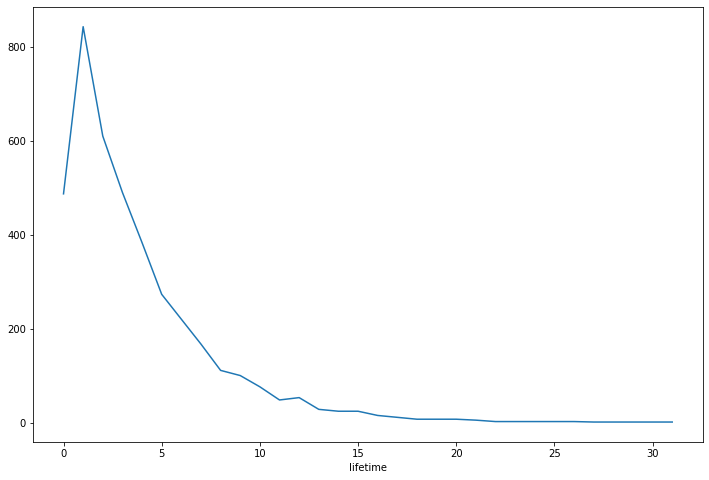

In [11]:
# lifetime клиентов
df.groupby('lifetime')['age'].count().plot(figsize=(12,8))

In [12]:
# доли абонементов
df['contract_period'].value_counts(normalize=True)*100

1     55.175
12    24.000
6     20.825
Name: contract_period, dtype: float64

In [13]:
# отток среди клиентов от 1 года
df.query('lifetime >= 12').groupby('churn').count()

,near_location,partner,promo_friends,age,lifetime,contract_period,month_to_end_contract,group_visits,avg_class_frequency_total,avg_class_frequency_current_month,avg_additional_charges_total
churn,,,,,,,,,,,
0,192,192,192,192,192,192,192,192,192,192,192


In [14]:
# отток среди клиентов от 6 месяцев
df.query('lifetime >= 6').groupby('churn').count()

,near_location,partner,promo_friends,age,lifetime,contract_period,month_to_end_contract,group_visits,avg_class_frequency_total,avg_class_frequency_current_month,avg_additional_charges_total
churn,,,,,,,,,,,
0,908,908,908,908,908,908,908,908,908,908,908
1,6,6,6,6,6,6,6,6,6,6,6


Мы видим, что предложено 3 вида абонементов 1, 6 и 12 месяцев. 55% всех абонементов приходится на 1 месячные. Среди них максимальный отток клиентов. Можно предположить, что попробовав 1 месяц многие не возвращаются в фитнес-центр. Самые лояльные клиенты посещали более года. Даже среди тех, кто посещает от полугода отток минимален. 

Тут без машинного обучения понятно, что плохо работают с новыми клиентами и не заинтересовывают их в продолжении пользования услугами фитнес-центра. Отсюда и низкая посещаемость групповых занятий, и пользование доп услугами. 

Рекомендации: усилить работу с новыми клиентами, предложить абонемент на 3 месяца, чтобы клиенты успели проникнуться положительным эффектом.

### Гистограммы и распределения признаков для тех, кто ушёл (Отток) и тех, кто остался (Активные)

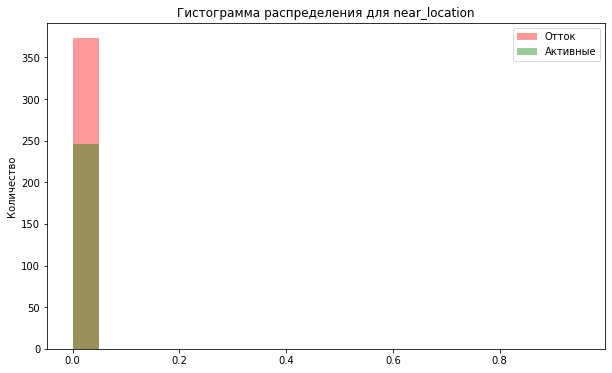

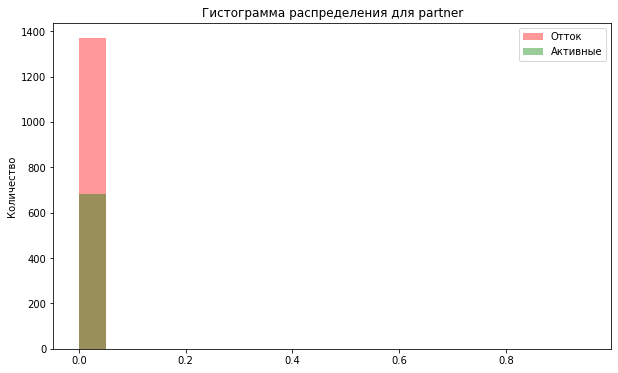

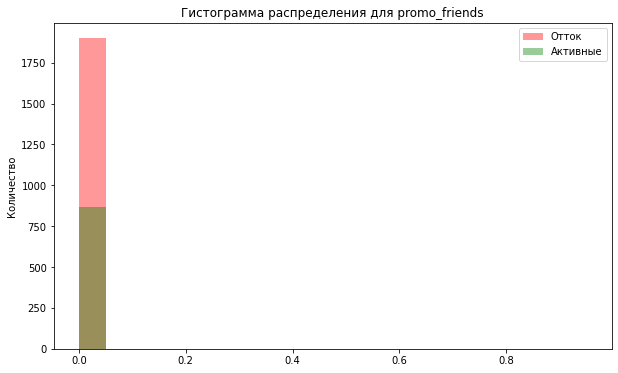

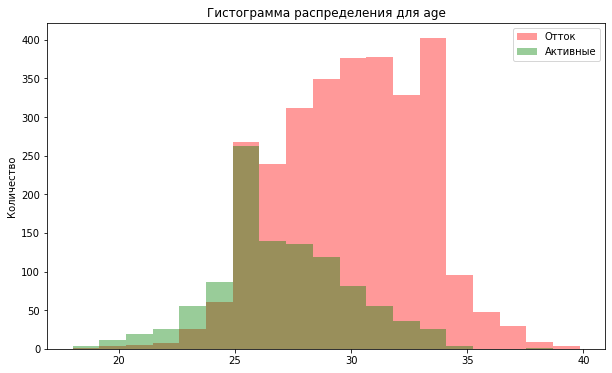

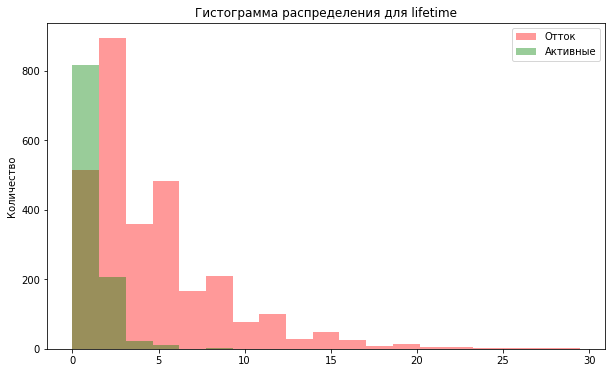

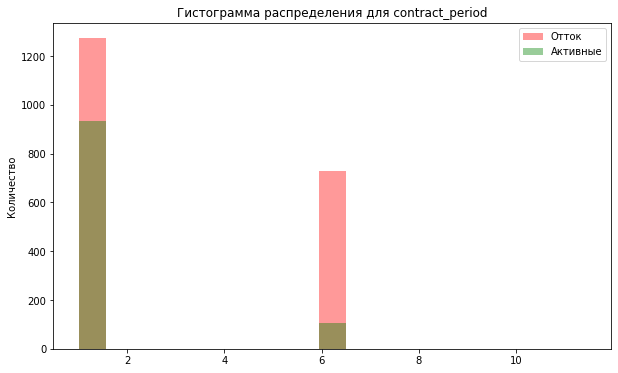

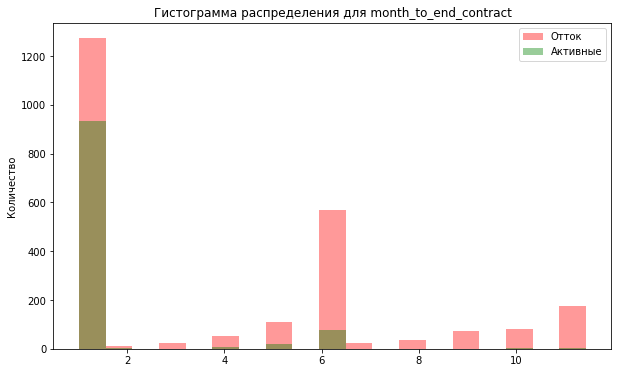

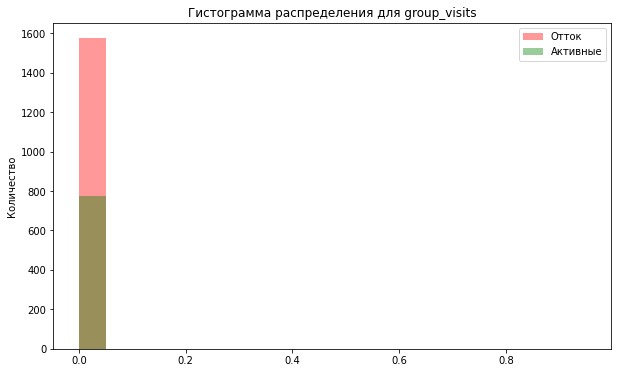

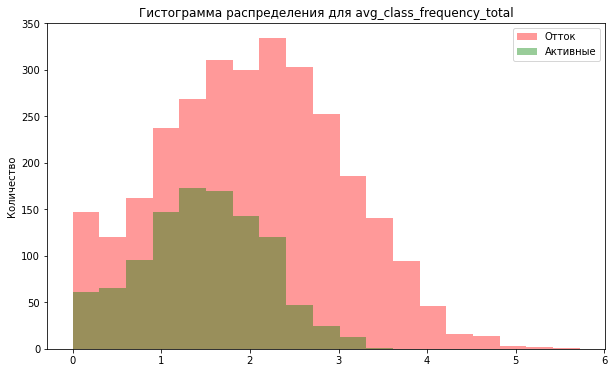

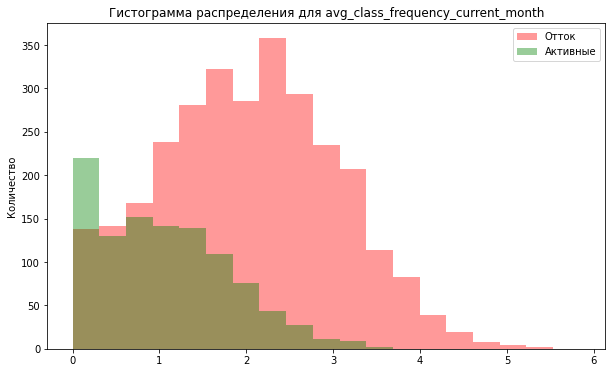

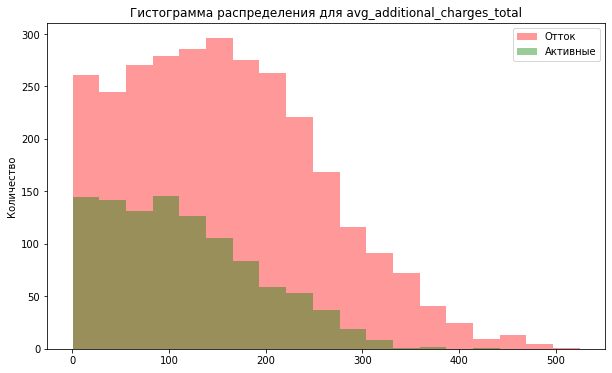

In [15]:
X=df.drop('churn',axis=1)
for i in X.columns:
    churn = list(df[df['churn'] == 0][i].dropna())
    active = list(df[df['churn'] == 1][i].dropna())
    
    xmin = min(min(churn), min(active))
    xmax = max(max(churn), max(active))
    width = (xmax - xmin)/20
    
    plt.figure(figsize=(10, 6))
    sns.distplot(churn,color='r', kde=False, bins=np.arange(xmin,xmax,width))
    sns.distplot(active,color='g', kde=False, bins=np.arange(xmin,xmax,width))
    plt.legend(['Отток', 'Активные'])
    plt.title('Гистограмма распределения для {}'.format(i))
    plt.ylabel('Количество')
    plt.show()

### Матрица корреляций

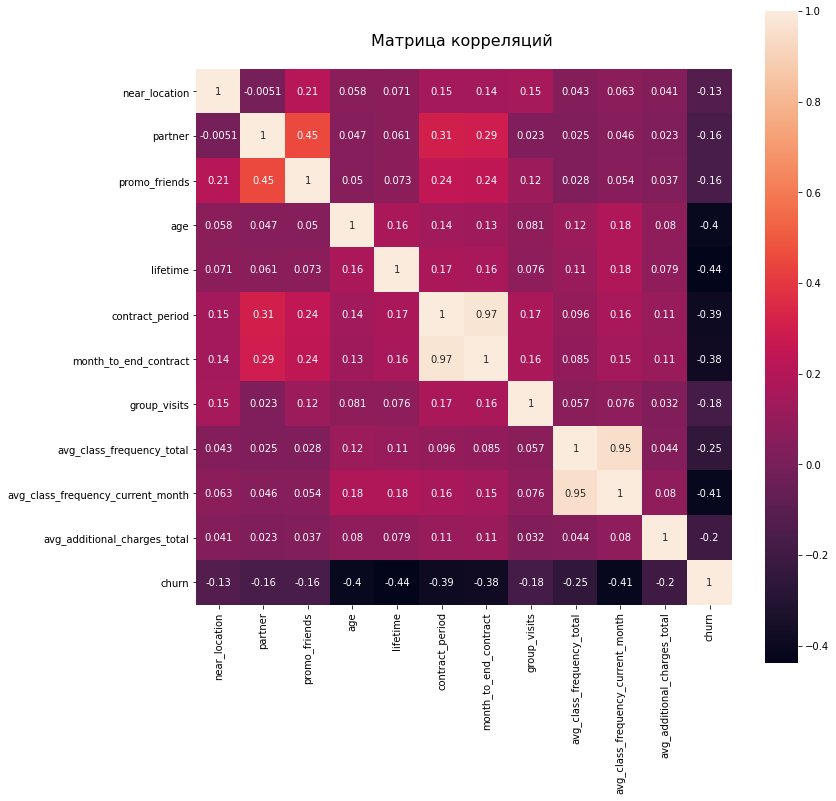

In [16]:
df_corr = df.corr()


plt.figure(figsize=(12,12))
sns.heatmap(df_corr, square=True, annot=True)
plt.title('Матрица корреляций \n', fontsize = 16)
plt.show()

Значительная(превышает 0,8)  корреляция между признаками:
- `month_to_end_contract` и `contract_period`

- `avg_class_frequency_current_month` и `avg_class_frequency_total`

In [17]:
# Чтобы избавиться от мультиколлинеарности удалим month_to_end_contract и avg_class_frequency_current_month
col_drop = ['month_to_end_contract', 'avg_class_frequency_current_month']
df = df.drop(col_drop, axis=1)

### Шаг 3. Постройте модель прогнозирования оттока клиентов

#### Разбейте данные на обучающую и валидационную выборку функцией train_test_split()

In [18]:
# разделяем данные на признаки (матрица X) и целевую переменную (y)
X = df.drop('churn', axis = 1)
y = df['churn']

In [19]:
# разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [20]:
for sample in X_train, X_test, y_train, y_test:
    print(sample.shape)

(3200, 9)
(800, 9)
(3200,)
(800,)


Обучающие выборки по 3200 строк, тестовые по 800, итого 4000

#### Обучите модель на train-выборке двумя способами

In [21]:
# стандартизируем данные 
scaler = StandardScaler()

# обучаем scaler на обучающей выборке
scaler.fit(X_train)

# стандартизируем обучающую выборку
X_train_st = scaler.transform(X_train)

# стандартизируем тестовую выборку
X_test_st = scaler.transform(X_test)

#### Логистическая регрессия

In [22]:
# задаём алгоритм для модели
lr_model = LogisticRegression(solver='liblinear', random_state=0)

In [23]:
# обучаем модель
lr_model.fit(X_train_st, y_train)

LogisticRegression(random_state=0, solver='liblinear')

In [24]:
# делаем прогноз
lr_predictions = lr_model.predict(X_test_st)

# получаем вероятность принадлежности объекта к первому или второму классу
lr_probabilities = lr_model.predict_proba(X_test_st)[:,1]

#### Случайный лес

In [25]:
# зададим алгоритм для новой модели на основе алгоритма случайного леса
rf_model = RandomForestClassifier(n_estimators=100, random_state=0)

In [26]:
# обучим модель случайного леса
rf_model.fit(X_train_st, y_train)

RandomForestClassifier(random_state=0)

In [27]:
# воспользуемся обученной моделью, для прогноза
rf_predictions = rf_model.predict(X_test_st)
rf_probabilities = rf_model.predict_proba(X_test_st)[:, 1]

#### Оцените метрики accuracy, precision и recall для обеих моделей на валидационной выборке. Сравните по ним модели.

In [28]:
# определим функцию, которая будет выводить метрики
def print_all_metrics(y_test, predictions, title='Метрики классификации'):
    print(title)
    print('\tAccuracy:  {:.2f}'.format(accuracy_score(y_test, predictions)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_test, predictions)))
    print('\tRecall:    {:.2f}'.format(recall_score(y_test, predictions)))

In [29]:
print_all_metrics(
    y_test,
    lr_predictions,
    title='Метрики для логистической регрессии:',
)

Метрики для логистической регрессии:
	Accuracy:  0.90
	Precision: 0.78
	Recall:    0.80


In [30]:
print_all_metrics(
    y_test,
    rf_predictions,
    title='Метрики для модели случайного леса:'
)

Метрики для модели случайного леса:
	Accuracy:  0.90
	Precision: 0.79
	Recall:    0.78


- accuracy - доля верно угаданных ответов из всех прогнозов
- precision - показывает долю правильных ответов только среди целевого класса
- recall - сколько реальных объектов "1" класса смогли обнаружить с помощью модели

В целом можно сказать, что модели справляются со своими задачами. Precision лучше у случайного леса, Recall у логистической регрессии.

### Шаг 4. Сделайте кластеризацию клиентов

#### Агломеративная иерархическая кластеризация

#### Cтандартизируем данные

In [31]:
sc = StandardScaler()
X_sc = sc.fit_transform(X)

#### Cтроим матрицу расстояний

In [32]:
# строим матрицу расстояний
linked = linkage(X_sc, method = 'ward') 

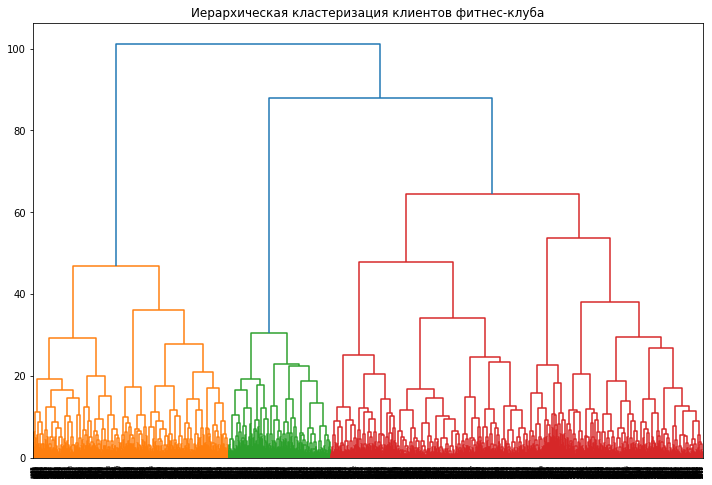

In [33]:
# рисуем дендрограмму
plt.figure(figsize=(12, 8))  
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация клиентов фитнес-клуба')
plt.show() 

##### Вывод
На основании графика можно выделить 3 кластера

In [34]:
# Попробуем сделать кластеризацию всего датафрейма с учетом оттока
df_sc = sc.fit_transform(df)

In [35]:
# строим матрицу расстояний
linked_df = linkage(df_sc, method = 'ward') 

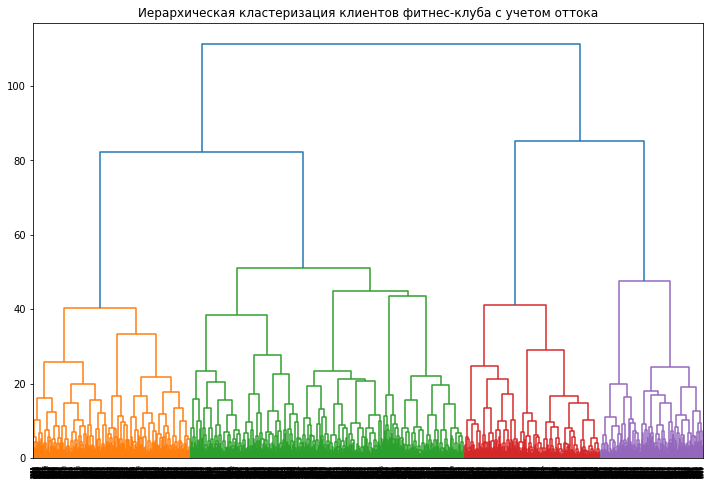

In [36]:
# рисуем дендрограмму
plt.figure(figsize=(12, 8))  
dendrogram(linked_df, orientation='top')
plt.title('Иерархическая кластеризация клиентов фитнес-клуба с учетом оттока')
plt.show() 

##### Вывод
С учетом оттока можно выделить 4 кластера

#### Обучаем модель кластеризации на основании алгоритма K-Means

In [37]:
# задаём модель k_means с числом кластеров 5 и фиксируем значение random_state
km = KMeans(n_clusters=5, random_state=0) 

# применяем алгоритм к данным и формируем вектор кластеров 
labels = km.fit_predict(X_sc)

In [38]:
# сохраним метки кластера в поле датасета
df['cluster'] = labels

#### Средние значения признаков для кластеров

In [39]:
clusters = df.groupby(['cluster']).mean()

In [40]:
clusters.T

cluster,0,1,2,3,4
near_location,1.000000,0.996113,1.000000,0.000000,0.954683
partner,0.246776,0.960155,0.244014,0.490000,0.495468
promo_friends,0.058469,0.941691,0.084379,0.071667,0.241692
age,28.584695,29.574344,29.458381,28.681667,30.262840
lifetime,2.444540,3.634597,2.850627,2.783333,12.525680
contract_period,2.950129,7.448980,4.461802,2.945000,5.888218
group_visits,0.000000,0.479106,1.000000,0.228333,0.429003
avg_class_frequency_total,1.764249,1.931320,1.920231,1.765080,2.217033
avg_additional_charges_total,140.112487,154.498117,146.463808,136.832314,167.061566
churn,0.414445,0.133139,0.224629,0.408333,0.000000


Можно сказать, что:
- кластер `0` никогда не ходит на групповые занятия
- кластер `2` всегда ходит на групповые занятия
- локация кластера `3` не в районе фитнес-центра
- в кластере `4` нет оттока в текущем месяце

#### Построение распределения признаков для кластеров

In [41]:
# функция отрисовки графиков попарных признаков для кластеров
def show_clusters_on_plot(df, x_name, y_name, cluster_name):
    plt.figure(figsize=(5, 5))
    sns.scatterplot(df[x_name], df[y_name], hue=df[cluster_name], palette='Paired')
    
    plt.title('{} vs {}'.format(x_name, y_name))
    plt.show()

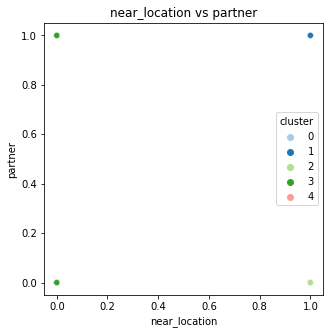

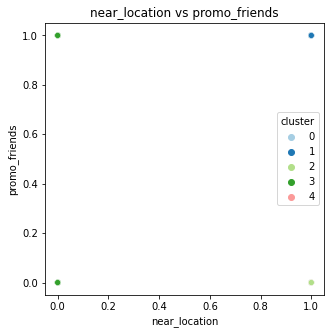

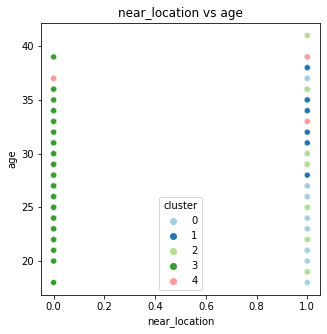

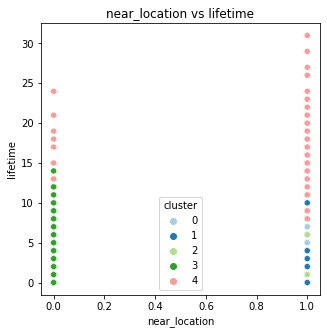

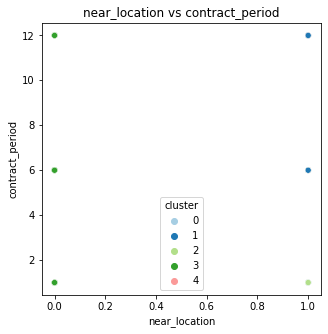

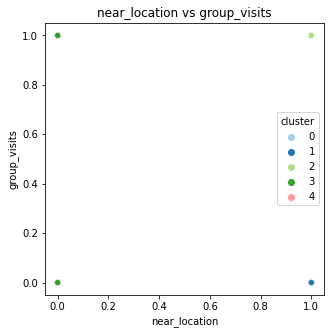

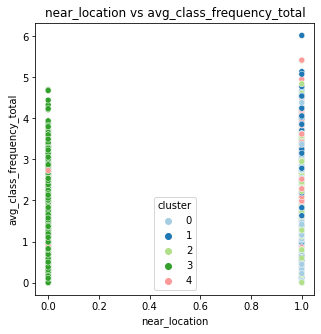

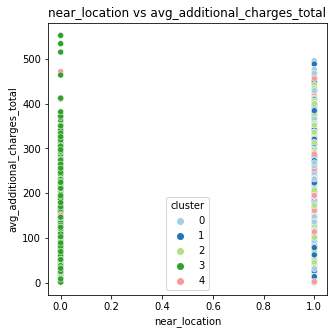

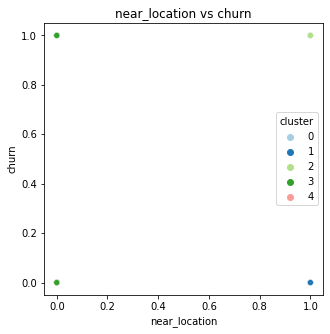

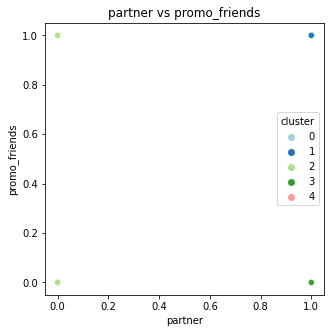

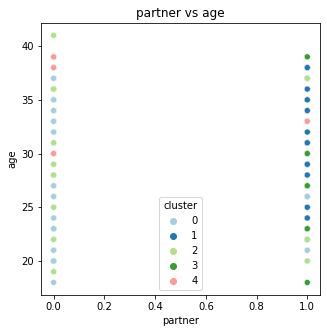

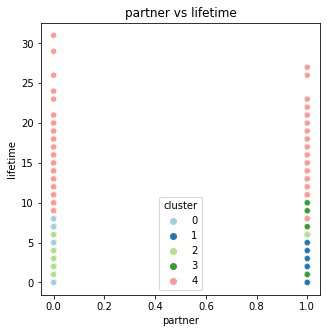

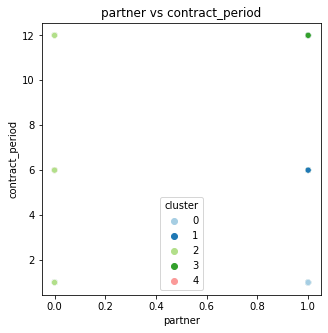

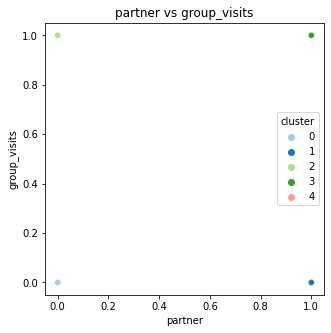

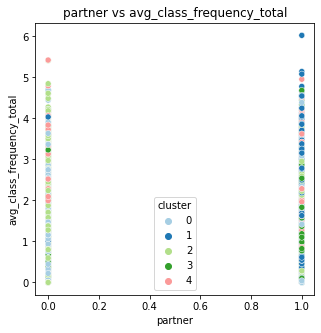

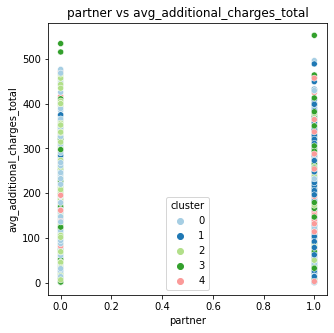

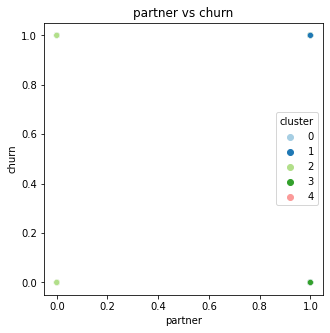

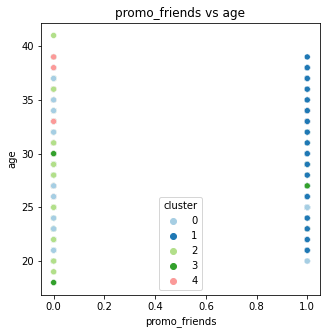

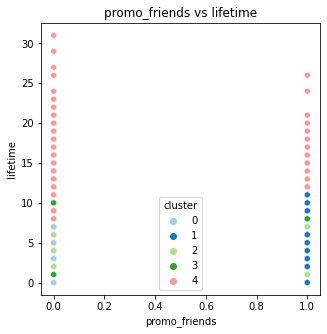

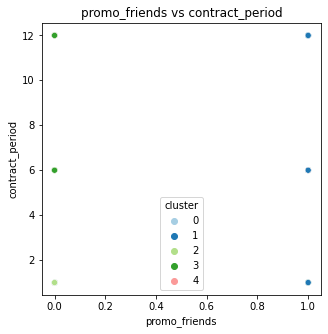

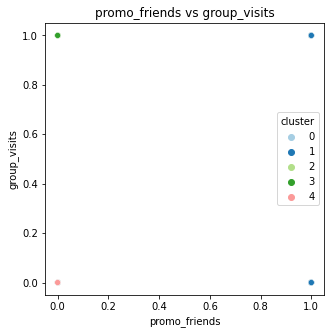

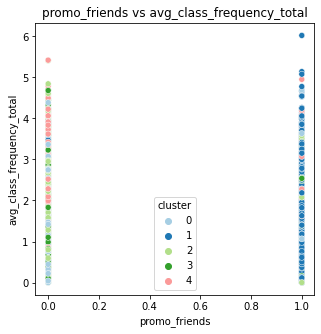

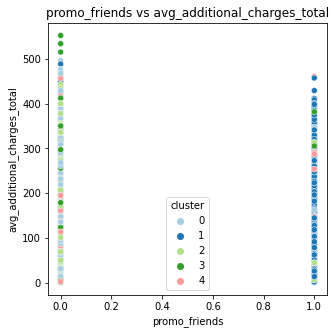

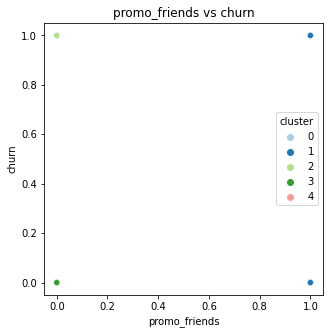

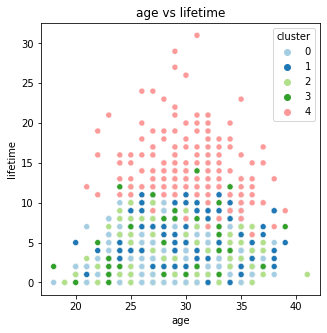

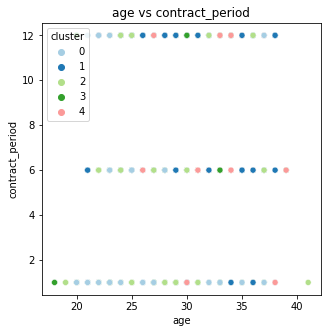

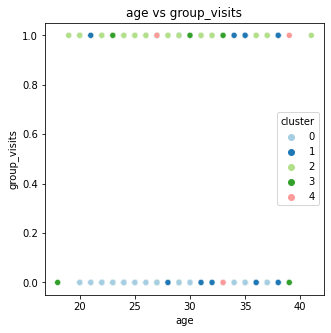

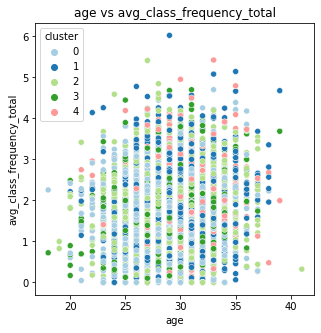

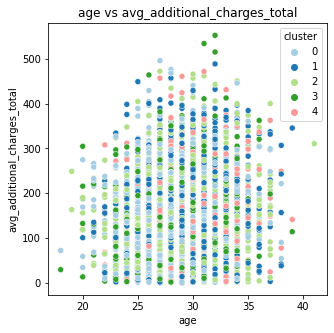

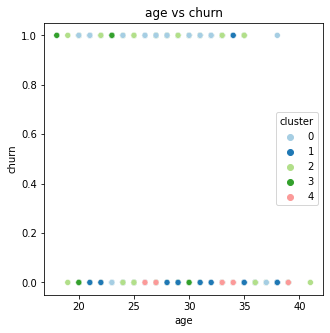

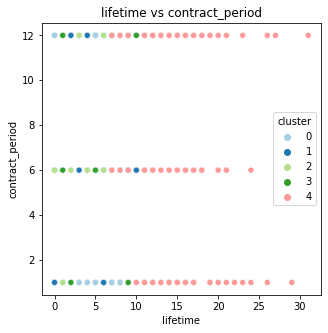

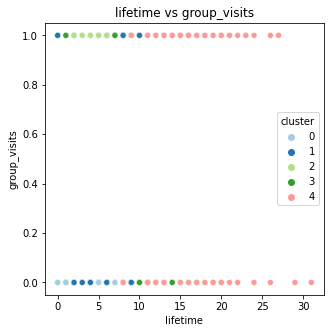

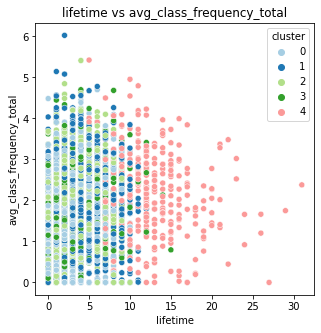

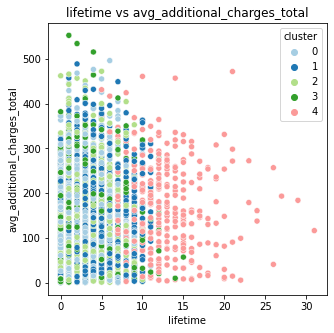

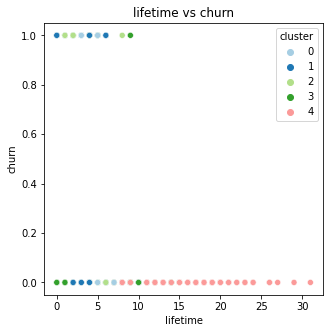

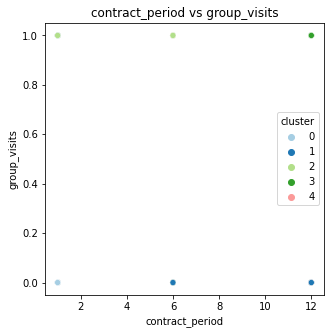

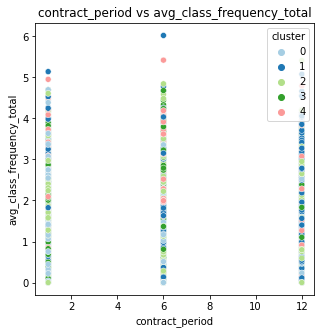

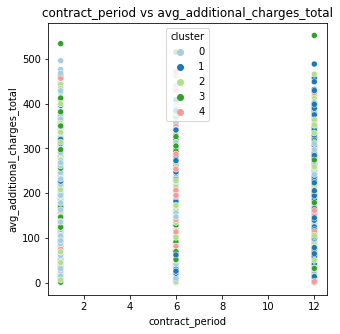

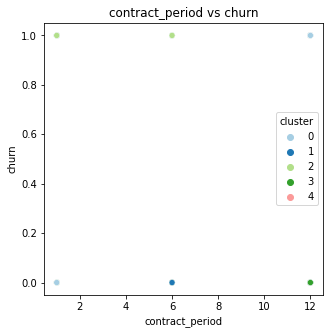

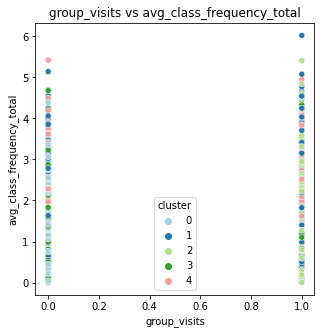

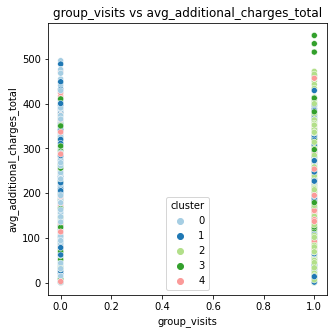

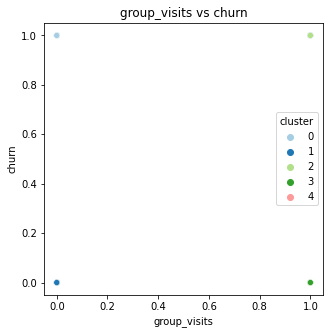

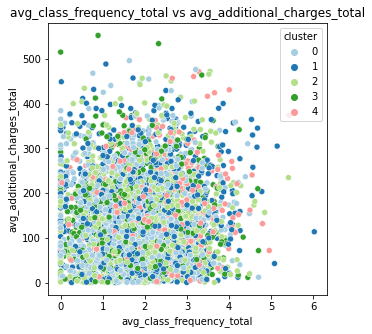

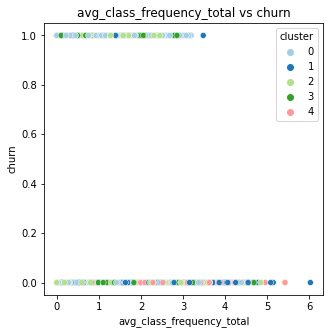

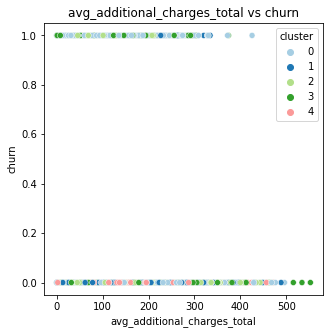

In [42]:
# отрисуем графики для попарных сочетаний признаков с разметкой по кластерам
col_pairs = list(itertools.combinations(df.drop('cluster', axis=1).columns, 2))
for pair in col_pairs:
    show_clusters_on_plot(df, pair[0], pair[1], 'cluster')

Не очень информативные графики получились. Попарно сравниванивать категориальные признаки видимо не стоит.
Можно выделить сравнение с lifetime, где визуально местами просматриваются границы.

#### Доля оттока каждого полученного кластера

In [43]:
df.groupby('cluster').agg({'churn':'mean'})*100

,churn
cluster,
0,41.444540
1,13.313897
2,22.462942
3,40.833333
4,0.000000


Самый надежный кластер `4` - нет оттока, самые не надежные кластеры `0` и `3`.

### Шаг 5. Выводы
Изучив датасет мы пришли к выводу что он пригоден к анализу.

При проведении исследовательского анализа данных мы выяснили, что многие клиенты не возвращаются после первого месяца занятий.
Самые лояльные клиенты занимаются более 1 года.

Признаками оттока можно назвать:
- срок абонемента 1 месяц
- низкая посещаемость групповых занятий
- редкая покупка дполнительных услуг

Мы сделали предположение, что клиенты покупают абонемент на 1 месяц, не успевают во всем разобраться и в полной мере оценить преимущества фитнес-клуба.

Для проверки своей гипотезы мы построили две модели прогнозирования оттока клиентов. Метрики показали, что модели довольно верно прогнозируют отток.

Затем разделили клиентов на кластеры.
Методом агломеративной иерархической кластеризации выделил 3 кластера.
Методу K-Means мы задали 5 кластеров.

Анализ средних показателей кластеров не опроверг первоначальную ранее сделанные предположения. Чем дольше занимается клиент тем меньше вероятность, что он покинет фитнес-клуб.

Рекомендуемые меры по удержанию клиентов:
- усилить работу с новыми клиентами,
- предложить абонемент на 3 месяца, чтобы клиенты успели проникнуться положительным эффектом.